# Aristos
This notebook includes the raw traces, data and code for generating the figures in the featured paper.

We preserve the figure labels from the paper and delineate each code cell accordingly. Each cell contains the following:
- Documentation
- Dataset and code for a specific figure

We start with necessary imports. Ensure to install missing packages via `pip`

In [2]:
import re
import bisect
import math

import numpy as np
from matplotlib import pyplot
from statsmodels.distributions.empirical_distribution import ECDF

## Data Loading
For a collective operation, below returns the min and max durations across concurrent executions on `num_gpus`

In [3]:
def get_collective_duration(data_file: str,
                            delimiter_regex: str,
                            gpus_per_node: int,
                            duration_index: int,
                            skip=1,
                            time_unit='ms') -> [list, list, float]:
    scaling_factor = 1  # us
    if time_unit == 'ms':
        scaling_factor = 1000
    elif time_unit == 's':
        scaling_factor = 1000 * 1000

    durations = open(data_file, "r")
    total_durations = []
    actual_durations = []
    max_delay = 0.0  # >= 0
    max_delay_index = 0
    p = re.compile(delimiter_regex)
    for _ in range(skip):
        durations.readline()  # skip header information

    line = durations.readline()

    j = 0
    while line:
        split_line = p.findall(line)
        duration = (float(split_line[duration_index - 1]) / scaling_factor)
        total = duration
        actual = duration

        line = durations.readline()

        for i in range(1, gpus_per_node):  # Obtain longest and shortest duration from concurrent executions
            split_line = p.findall(line)
            duration = (float(split_line[duration_index - 1]) / scaling_factor)  # microseconds to milliseconds
            total = max(duration, total)
            actual = min(actual, duration)
            line = durations.readline()

        if (total - actual) > max_delay:
            max_delay_index = j
            max_delay = (total - actual)
        total_durations.append(total)
        actual_durations.append(actual)
        j = j + 1
    return total_durations, actual_durations, max_delay_index

In [4]:
def single_plot(data_x: np.ndarray, data: list, header: str, x_title: str, out_name: str,
                color=None, y_title=None, labels=None, n_plots=None, stats=None, s_coords=None,
                x_lim_left=None, x_lim_right=None, y_lim_top=None, y_lim_bottom=None,
                plot_marker=None, sub_title=None):
    fig, axs = pyplot.subplots(figsize=(6, 5), dpi=300)
    fig.suptitle(header, fontsize=10)
    if n_plots == 1:
        axs.plot(data_x, data, color)
    else:
        for i in range(n_plots):
            axs.plot(data_x, data[i], color[i], label=labels[i], marker=plot_marker)
    if stats is not None:
        bbox = dict(boxstyle='round', fc='blanchedalmond', ec='orange', alpha=0.5)
        axs.text(s_coords[0], s_coords[1], stats, fontsize=8, bbox=bbox,
                 transform=axs.transAxes, horizontalalignment='right')
    axs.set_xlabel(x_title)

    if y_title != "":
        axs.set_ylabel(y_title)

    if sub_title is not None:
        axs.set_title(sub_title, fontsize=8)

    if x_lim_left is not None:
        axs.set_xlim(left=x_lim_left, right=x_lim_right)

    if y_lim_top is not None:
        axs.set_ylim(top=y_lim_top, bottom=y_lim_bottom)

    if labels is not None:
        axs.legend()
    axs.grid()

    fig.tight_layout()
    pyplot.savefig(out_name)
    pyplot.show()

In [5]:
def get_kernel_percentages(data_file: str, delimiter_regex: str, metadata: dict, skip=0) -> tuple[list, list]:
    percentages = []
    for _ in range(len(metadata)):
        percentages.append(0.0)

    summary = open(data_file, "r")
    p = re.compile(delimiter_regex)

    for _ in range(skip):
        summary.readline()

    line = summary.readline()
    non_misc_percentages = 0
    while line:
        split_summary = p.findall(line)
        time_percent = float(split_summary[0])

        if time_percent > 0.0:
            for i in range(10, len(split_summary)):
                stop_search = False
                j = 0
                # This is correct since dict remembers insertion order per https://stackoverflow.com/a/39980744
                for kernel_pattern in metadata.keys():
                    val = split_summary[i]
                    if re.match(kernel_pattern, val):
                        percentages[j] = percentages[j] + time_percent
                        non_misc_percentages = non_misc_percentages + time_percent
                        stop_search = True
                        break
                    j = j + 1
                if stop_search:
                    print(line)
                    break

        line = summary.readline()

    kernel_groups = list(metadata.values())
    kernel_groups.append("Misc")
    percentages.append(100.0 - non_misc_percentages)

    return kernel_groups, percentages

In [6]:
def get_kernel_breakdown(data_file: str, delimiter_regex: str, cutoff: float, skip=0, misc_index=-1) -> list:
    percentages = []

    summary = open(data_file, "r")
    p = re.compile(delimiter_regex)

    for _ in range(skip):
        summary.readline()

    line = summary.readline()
    non_misc_percentages = 0
    
    split_summary = p.findall(line)
    time_percent = float(split_summary[0])
    
    while time_percent >= cutoff:
        non_misc_percentages = non_misc_percentages + time_percent
        percentages.append(time_percent)
        
        line = summary.readline()
        split_summary = p.findall(line)
        time_percent = float(split_summary[0])
    
    percentages.insert(misc_index, 100.0 - non_misc_percentages)
    
    return percentages

In [7]:
# Adapted from https://matplotlib.org/stable/gallery/pie_and_polar_charts/pie_and_donut_labels.html
def plot_donut_chart(description: list, data: list, title: str, out_name:str, y_size=3) -> None:
    fig, ax = pyplot.subplots(figsize=(6, y_size), subplot_kw=dict(aspect="equal"), dpi=300)

    wedges, texts = ax.pie(data, wedgeprops=dict(width=0.5), startangle=-40)

    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    kw = dict(arrowprops=dict(arrowstyle="->"),
              bbox=bbox_props, zorder=0, va="center")

    for i, p in enumerate(wedges):
        ang = (p.theta2 - p.theta1) / 2. + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = f"angle,angleA=0,angleB={ang}"
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        ax.annotate('{}: {:.1f}%'.format(description[i], data[i]), xy=(x, y), xytext=(1.35 * np.sign(x), 1.4 * y),
                    horizontalalignment=horizontalalignment, **kw)

    ax.set_title(title, fontweight='bold')
    pyplot.savefig(out_name, format= 'pdf', bbox_inches='tight')
    pyplot.show()

In [8]:
def gen_batch_collective_duration(data_files: list,
                                  delimiter_regex: str,
                                  gpus_per_node: list,
                                  duration_index: int,
                                  skips=None,
                                  time_unit='ms') -> list:
    if skips is None:
        skips = [0, 0, 0]
    batch = []
    for filename, n_gpus, skip in zip(data_files, gpus_per_node, skips):
        t_dur, a_dur, max_i = get_collective_duration(data_file=filename,
                                                      delimiter_regex=delimiter_regex,
                                                      gpus_per_node=n_gpus,
                                                      duration_index=duration_index,
                                                      skip=skip,
                                                      time_unit=time_unit)
        batch.append((t_dur, a_dur, max_i))
    return batch


def plot_straggler_delays(dataset: list, output_names: list, file_prefix="", addenda=None, 
                          x_left=None, x_right=None) -> None:
    if addenda is None:
        addenda = []
        for _ in range(len(dataset)):
            addenda.append("")

    plot_stats = []
    coord = [(0.7, 0.8), (0.7, 0.9), (0.7, 0.65)]
    dur_unit = 'ms'

    for row in dataset:
        m_idx = row[2]
        plot_stats.append((f'max delay = {(row[0][m_idx] - row[1][m_idx]): .2f} ' + dur_unit + 
                           f'\n avg actual = {np.array(row[1]).mean(): .2f}' + dur_unit))

    for i in range(len(dataset)):
        output_name = "{}{}.pdf".format(file_prefix, re.sub(r'\s+', "_", output_names[i]))
        data_x = np.linspace(1, len(dataset[i][0]), num=len(dataset[i][0]), dtype=int)

        single_plot(data_x, [dataset[i][0], dataset[i][1]],
                    header="{} All-to-All Straggler Effect: {}".format(output_names[i], addenda[i]),
                    labels=["Total Time", "Actual Time"], stats=plot_stats[i], s_coords=coord[i], color=['tab:red', 'tab:green'],
                    out_name=output_name, y_title="Time ({})".format(dur_unit),
                    x_title="All-to-All Steps", n_plots=2, sub_title="Raw Distribution", x_lim_left=x_left, x_lim_right=x_right)


def plot_ecdf(dataset: list, output_names: list, file_prefix="", addenda=None) -> None:
    for i in range(len(dataset)):
        t_durs = np.array(dataset[i][0])
        a_durs = np.array(dataset[i][1])
        ecdf = ECDF((t_durs - a_durs))
        median_cdf = bisect.bisect(ecdf.y, 0.5)
        x_unit = 'ms'
        filtered_data = [v for v in ecdf.x if not math.isnan(v) and not math.isinf(v)]
        
        stats = (f'$\mu$ = {np.array(filtered_data).mean():.2f}{x_unit}\n'
             f'$median$ = {ecdf.x[median_cdf]:.2f}{x_unit}')
        
        output_name = "{}{}_ecdf.pdf".format(file_prefix, re.sub(r'\s+', "_", output_names[i]))
        single_plot(ecdf.x, ecdf.y,
                    header="{} All-to-All Straggler Effect ECDF: {}".format(output_names[i], addenda[i]),
                    color='tab:green', out_name=output_name, x_title="Delay ({})".format(x_unit), n_plots=1, sub_title="ECDF", stats=stats, s_coords=(0.7, 0.8))

In [34]:
values = get_kernel_breakdown("data/single/single_1x8_filtered_sum.txt", r"(\d+\.?\d+|[^\W_]+)", cutoff=6, skip=6, misc_index=0)
print(values)
# Manually obtained below from ./data/single_1x8_filtered_sum.txt
kernel_types = ["miscellaneous", "volta_128x128_s884", "apex_fused_dropout", "cutlass_fused_relu_256", "volta_s884_64x128_tn", "volta_s884_64x128_nn", "nccl_All-to-All", "cutlass_fused_relu_128"]

[49.2, 10.2, 7.9, 6.8, 6.7, 6.5, 6.4, 6.3]


## Communication Overhead: Figure 1

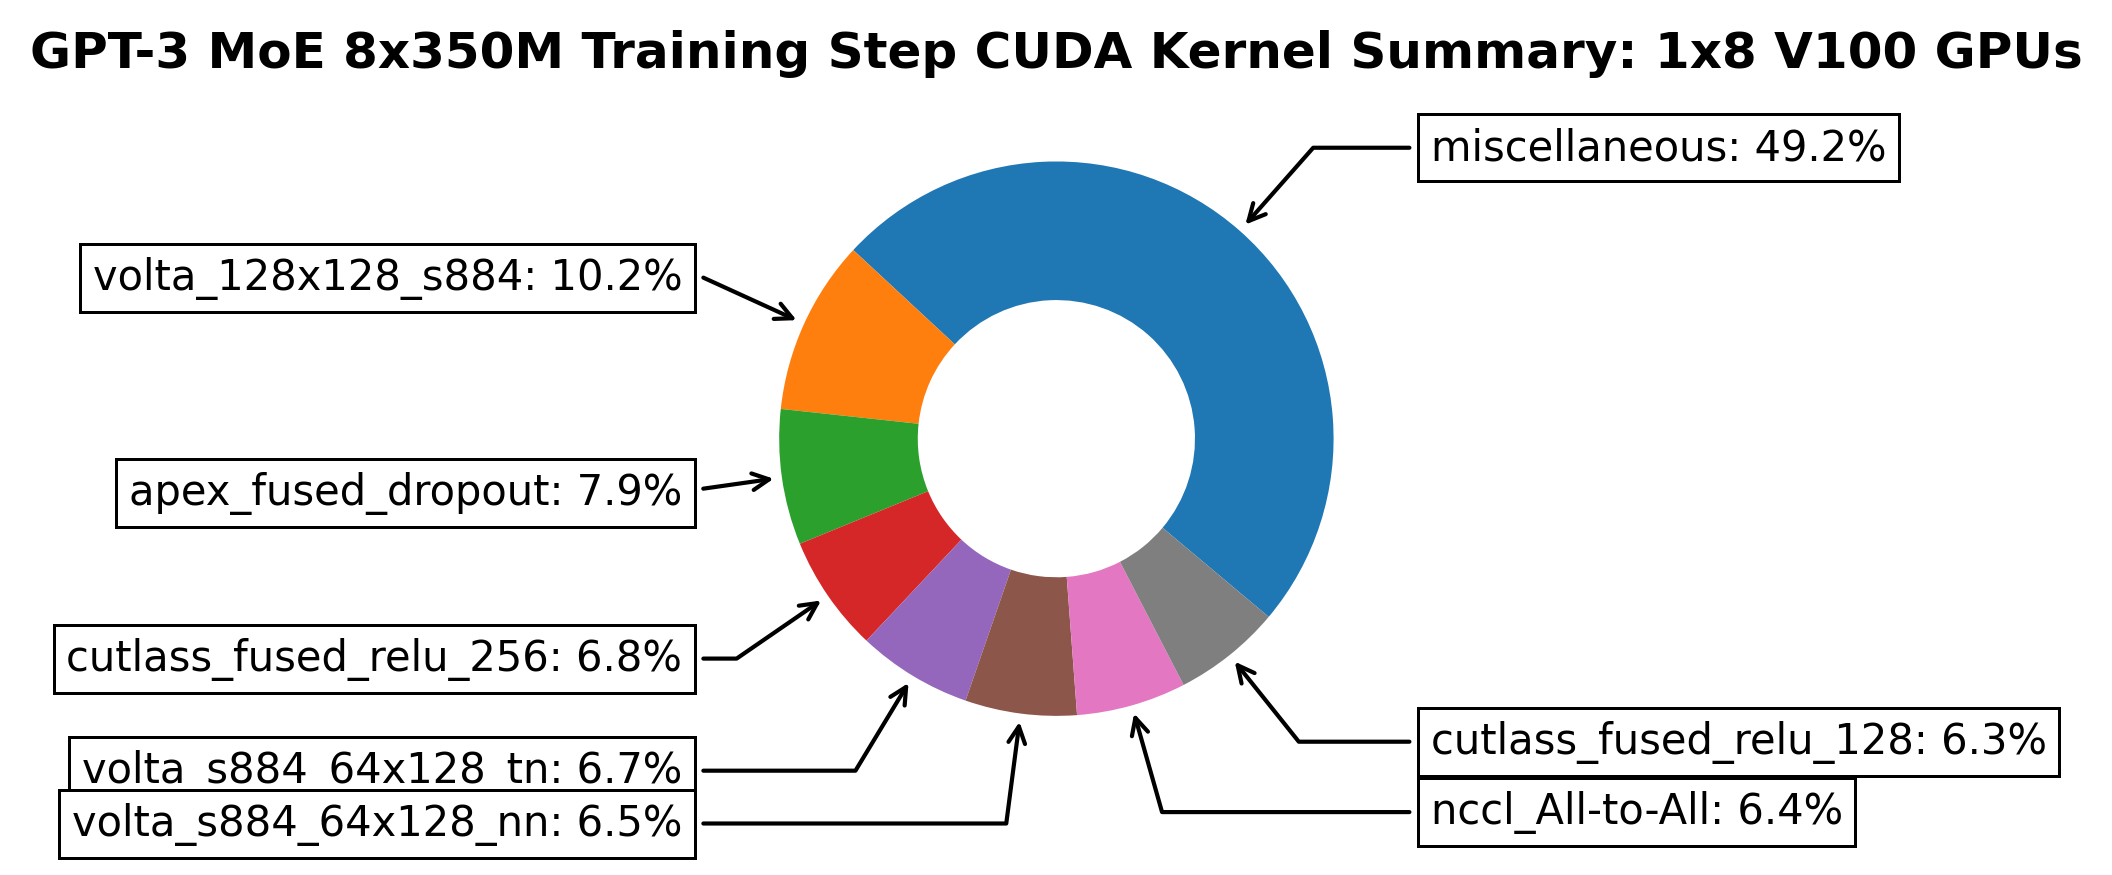

In [35]:
plot_donut_chart(kernel_types, values, "GPT-3 MoE 8x350M Training Step CUDA Kernel Summary: 1x8 V100 GPUs", "figures/single_trace_1x8_donut.pdf", y_size=3)

In [36]:
m_values = get_kernel_breakdown("data/multi/multi_8x4_1.3B_sum.txt", r"(\d+\.?\d+|[^\W_]+)", cutoff=5, skip=6, misc_index=0)
print(m_values)

m_kernel_types = ["miscellaneous", "nccl_All-to-All", "ampere_s16816_128x128_tn", "ampere_s16816_256x128", "ampere_s16816_128x128_nt", "ampere_s16816_128x256_tn", "ampere_s1688_256x128_tn", "apex_fused_dropout"]

[44.7, 14.7, 11.4, 9.7, 9.3, 5.2, 5.0]


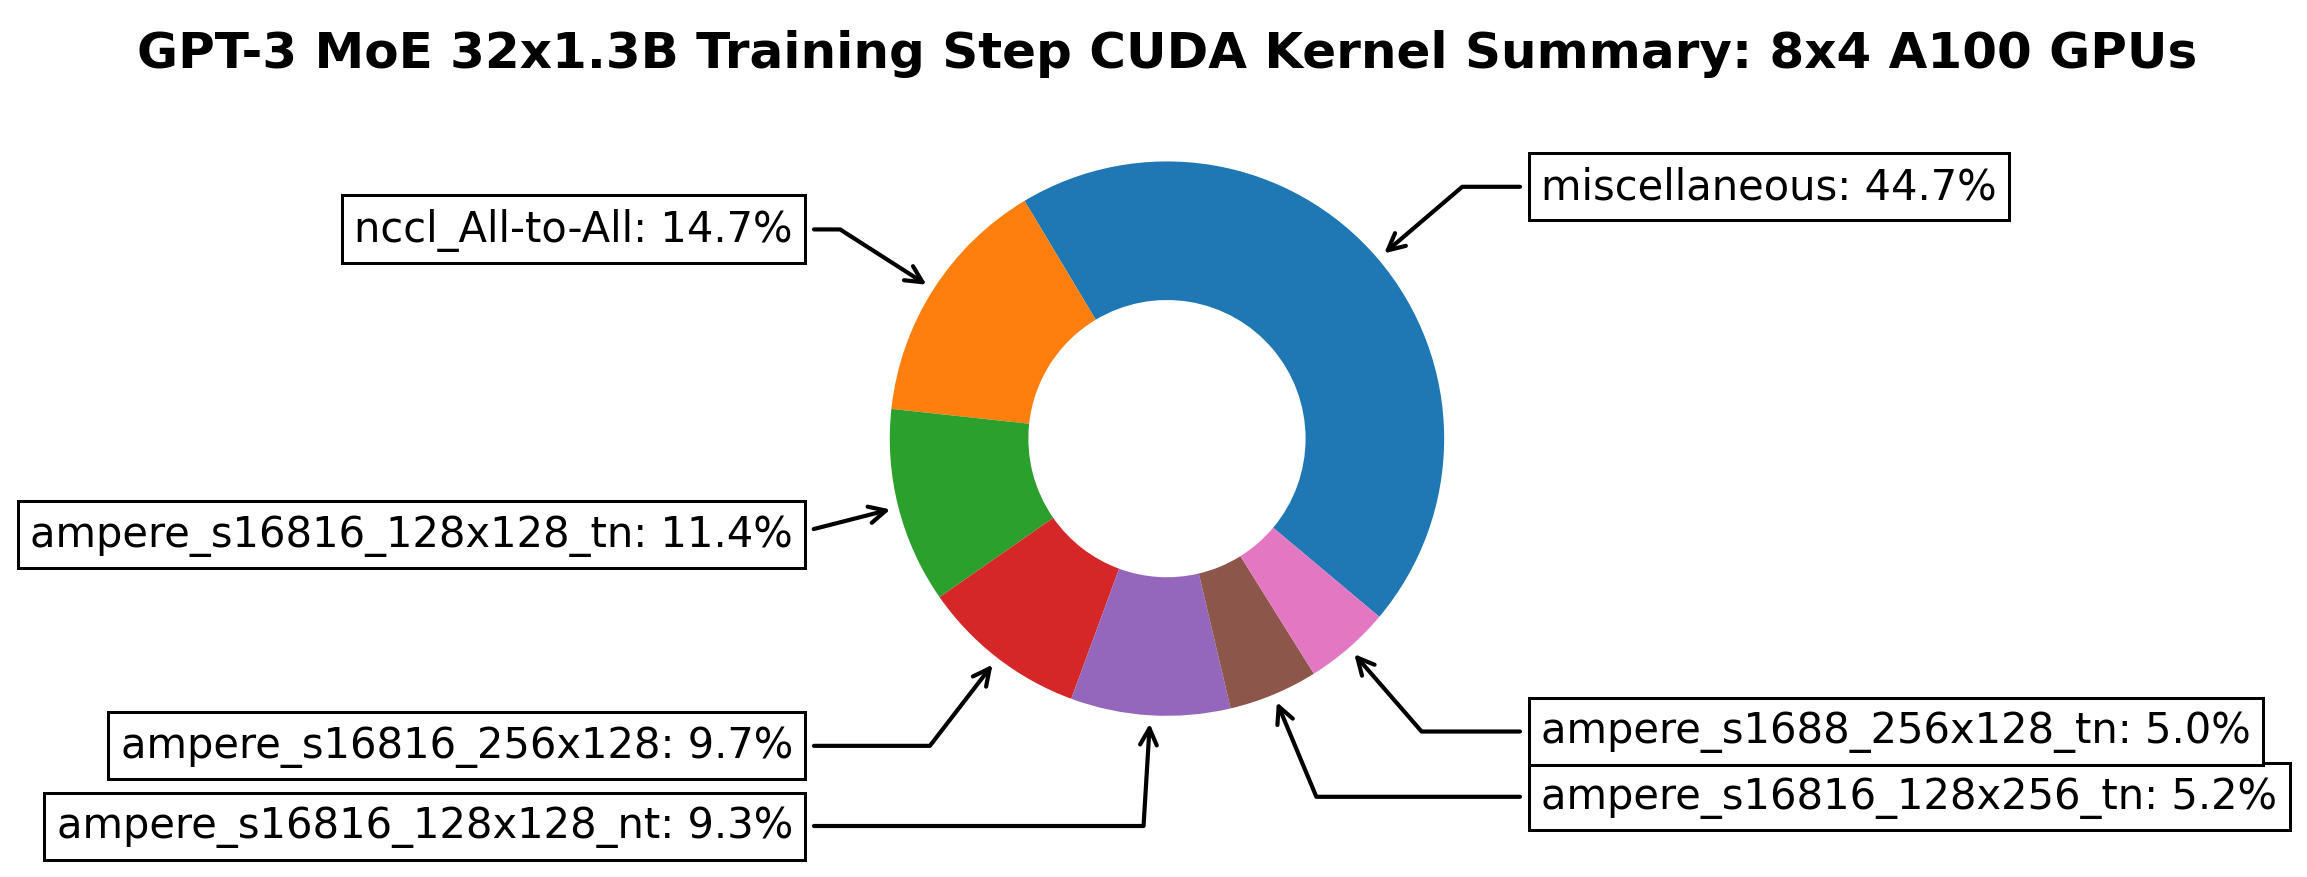

In [37]:
plot_donut_chart(m_kernel_types, m_values, "GPT-3 MoE 32x1.3B Training Step CUDA Kernel Summary: 8x4 A100 GPUs", "figures/multi_sum_8x4_1.3B_donut.pdf", y_size=3)

In [67]:
m_t_values = get_kernel_breakdown("data/multi/multi_8x4_350M_sum.txt", r"(\d+\.?\d+|[^\W_]+)", cutoff=4, skip=6, misc_index=0)
print(m_t_values)

m_t_kernel_types = ["miscellaneous", "nccl_All-to-All", "apex_fused_dropout", "ampere_s1688gemm_256x64_tn","tensor_scan_outer_dim", "ampere_s16816gemm_128x128_nt", "apex_softmax", "ampere_s16816gemm_128x128_nn", "ampere_s16816gemm_64x128_nn", "cutlass_fused_relu_256x128_tn"]

[44.599999999999994, 13.1, 7.0, 7.0, 6.0, 4.7, 4.6, 4.5, 4.3, 4.2]


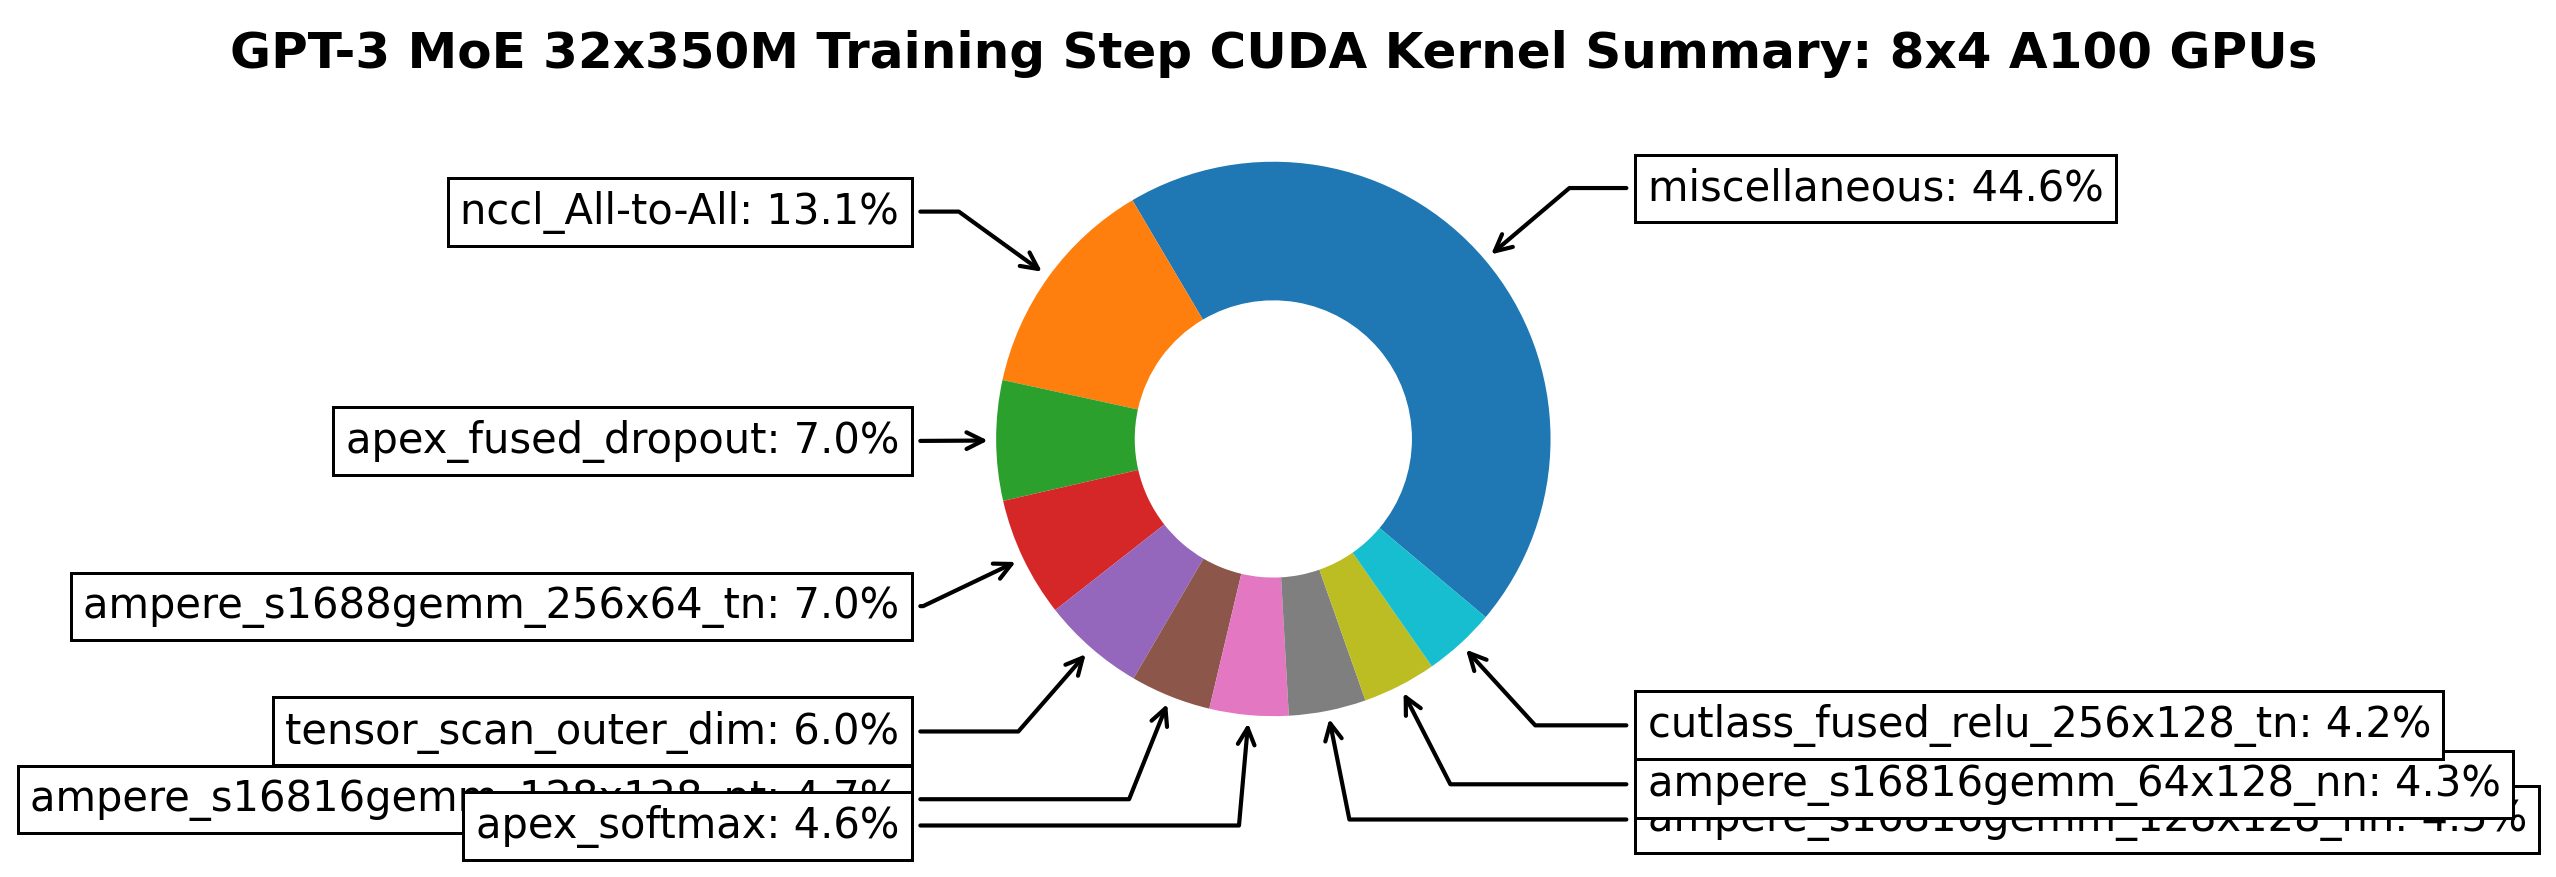

In [68]:
plot_donut_chart(m_t_kernel_types, m_t_values, "GPT-3 MoE 32x350M Training Step CUDA Kernel Summary: 8x4 A100 GPUs", "figures/multi_sum_8x4_350M_donut.pdf", y_size=3)

## Straggler Effect: Figure 2

In [15]:
delim = r"(\d+\.?\d+)"
delays_dataset = gen_batch_collective_duration(data_files=["data/single/single_1x8_350M_trace.txt",
                                                           "data/multi/multi_8x4_1.3B_trace.txt",
                                                           "data/multi/multi_8x4_350M_trace.txt"],
                                               delimiter_regex=delim,
                                               gpus_per_node=[8, 4, 4],
                                               duration_index=2,
                                               skips=[2, 2, 3],
                                               time_unit='ms')

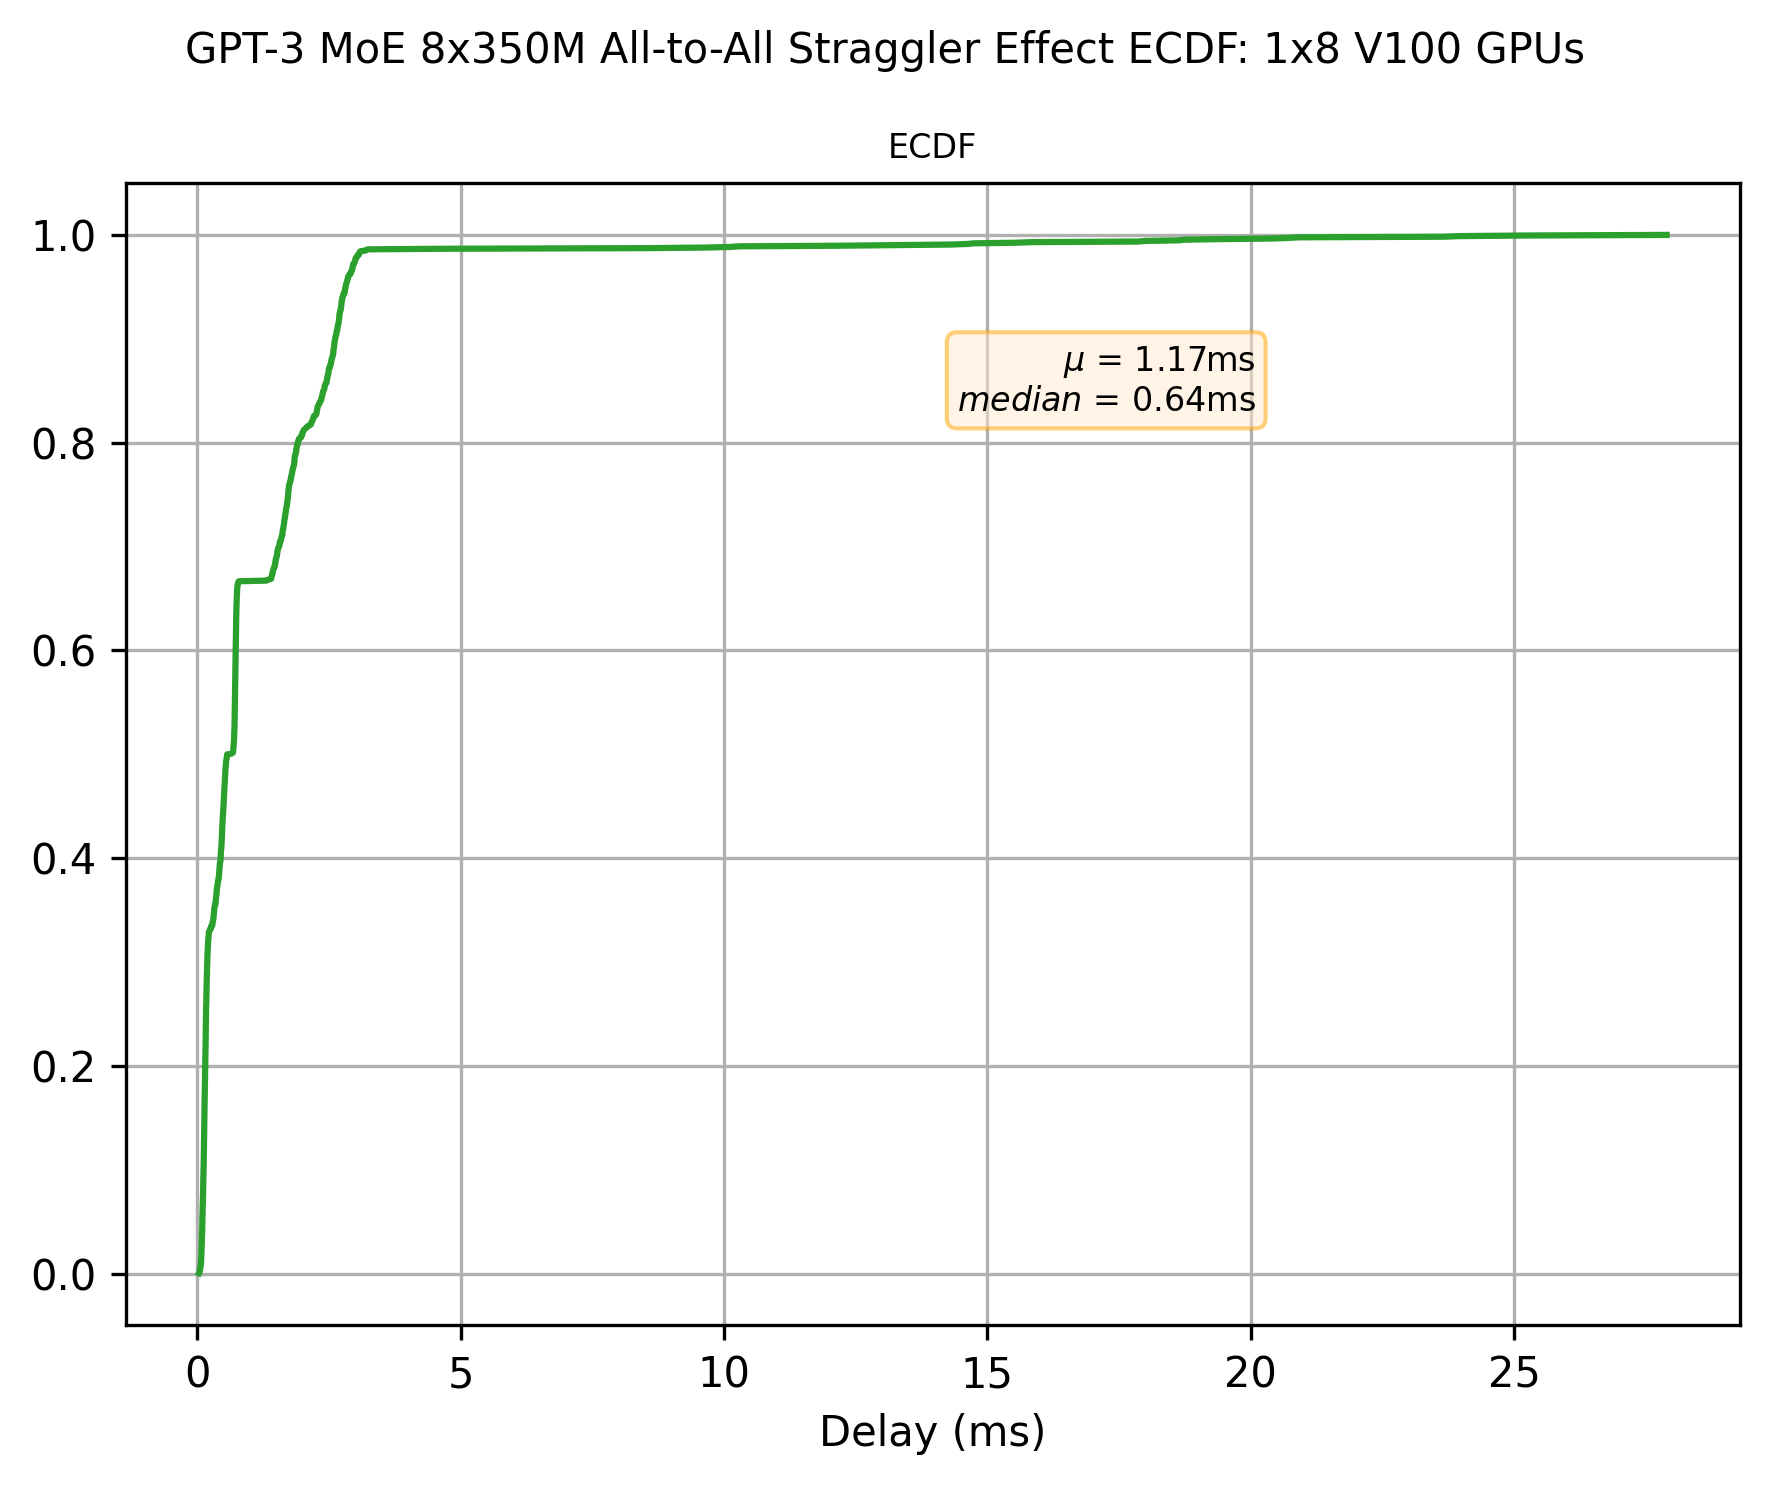

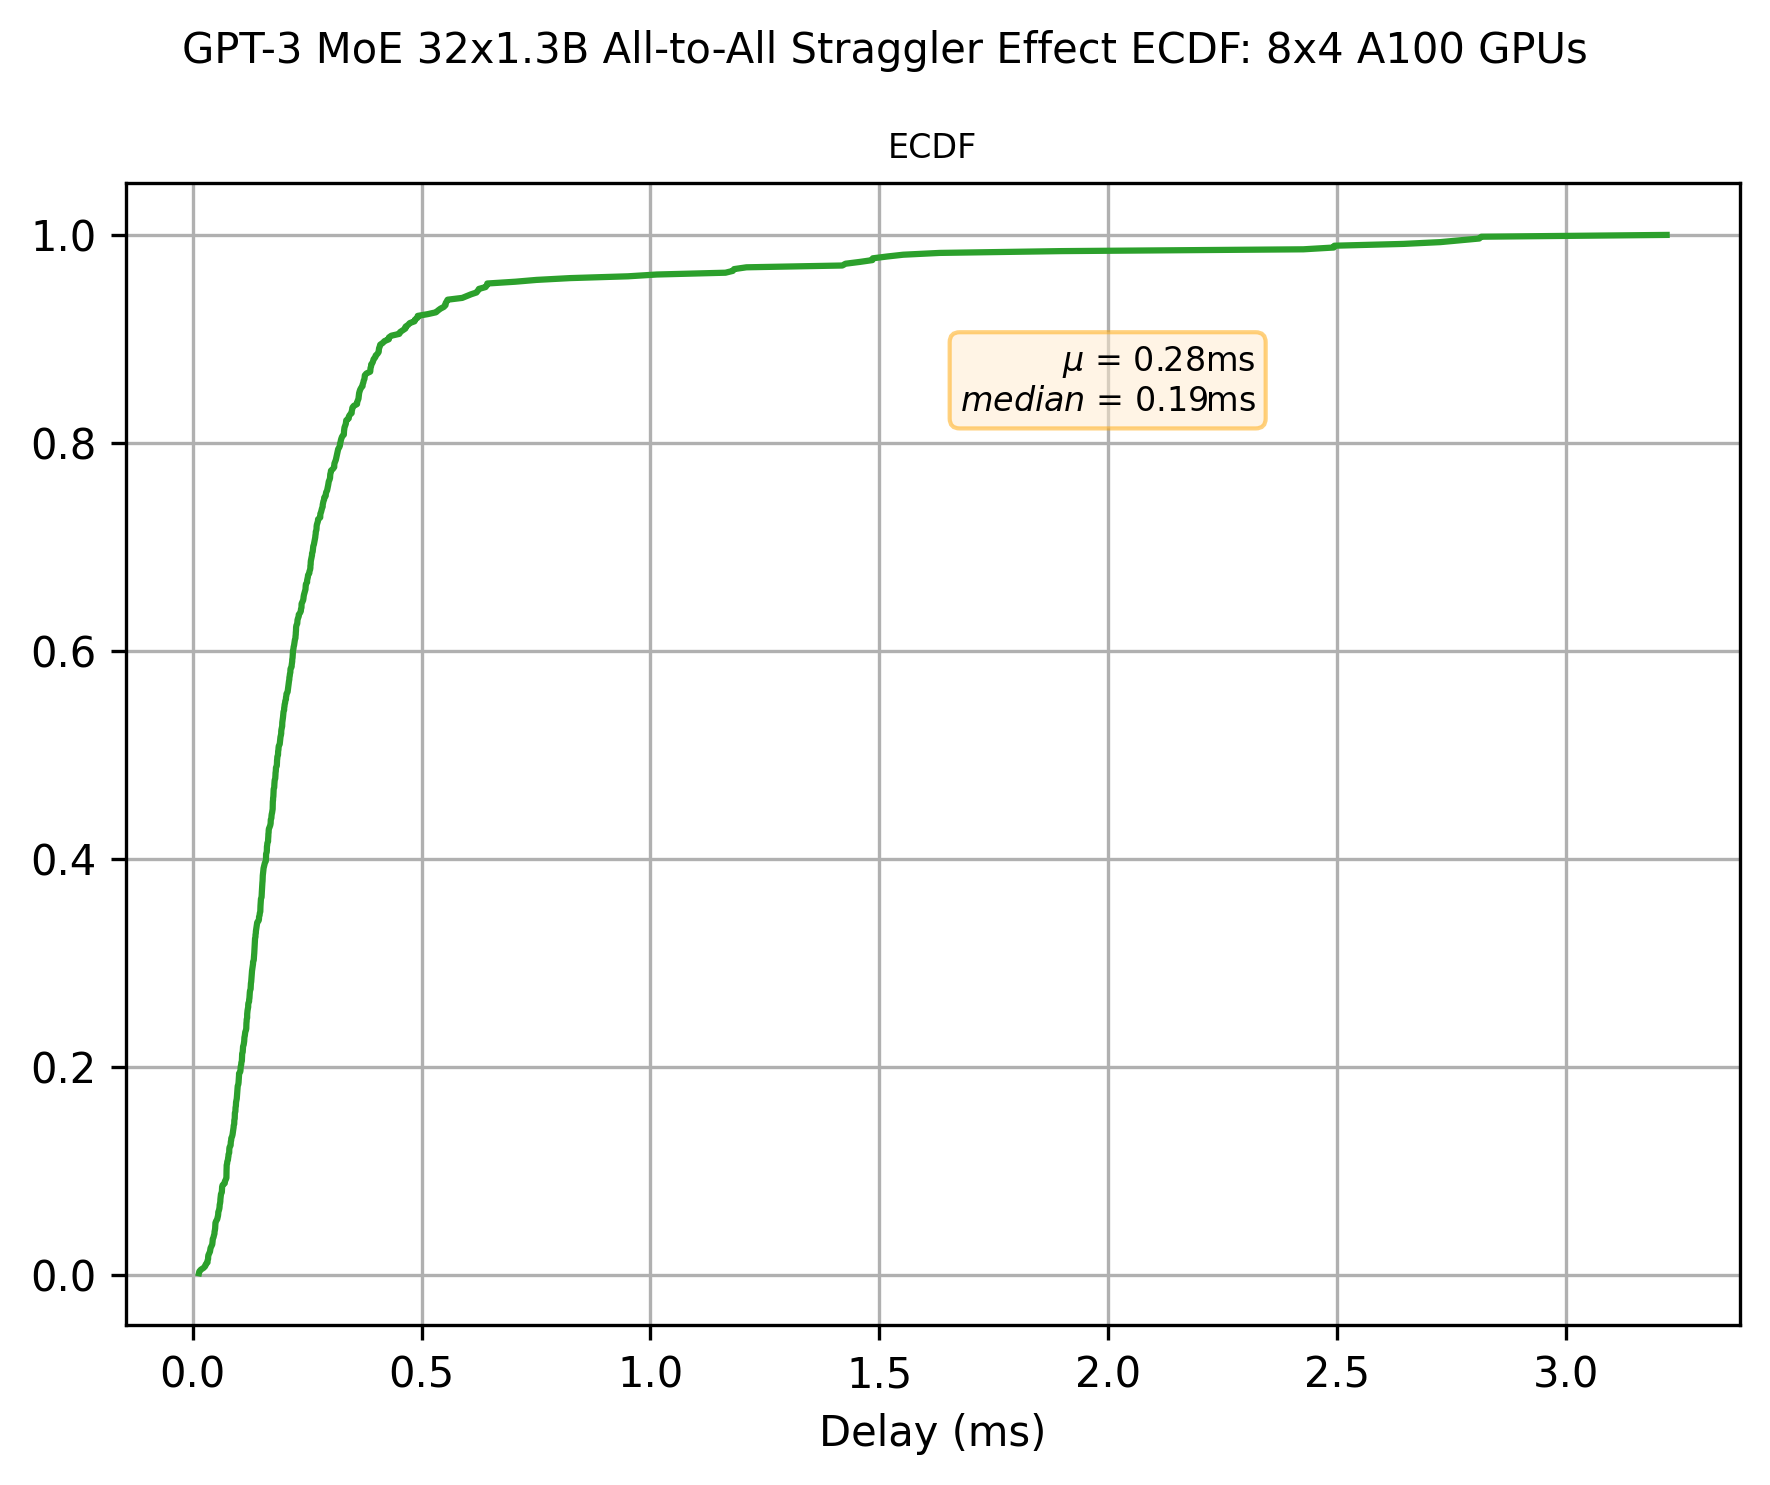

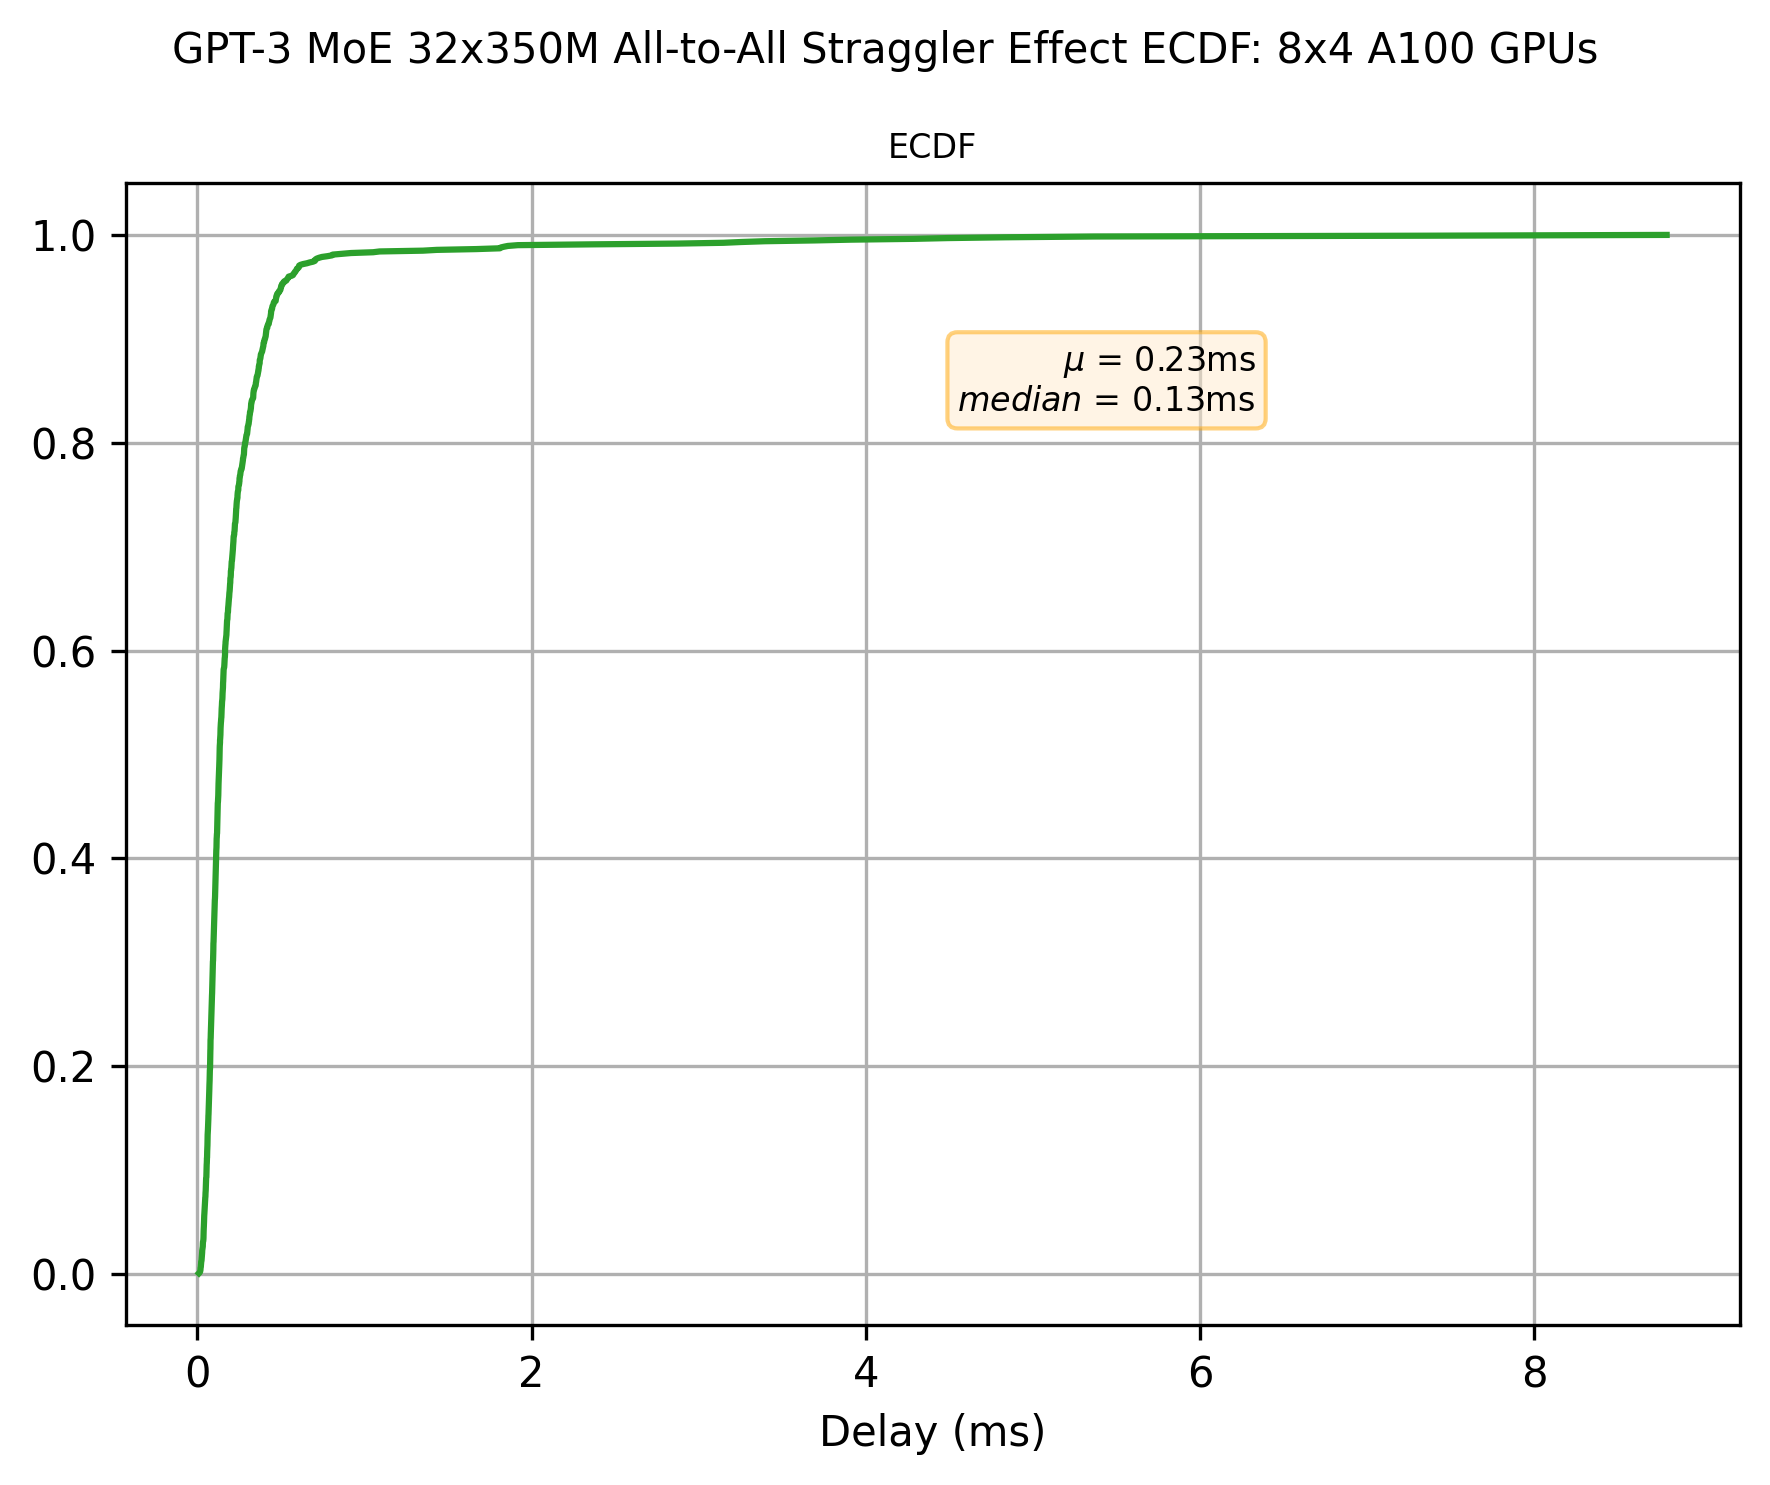

In [16]:
plot_ecdf(delays_dataset,
              output_names=["GPT-3 MoE 8x350M", "GPT-3 MoE 32x1.3B", "GPT-3 MoE 32x350M"],
              file_prefix='figures/',
              addenda=["1x8 V100 GPUs", "8x4 A100 GPUs", "8x4 A100 GPUs"])

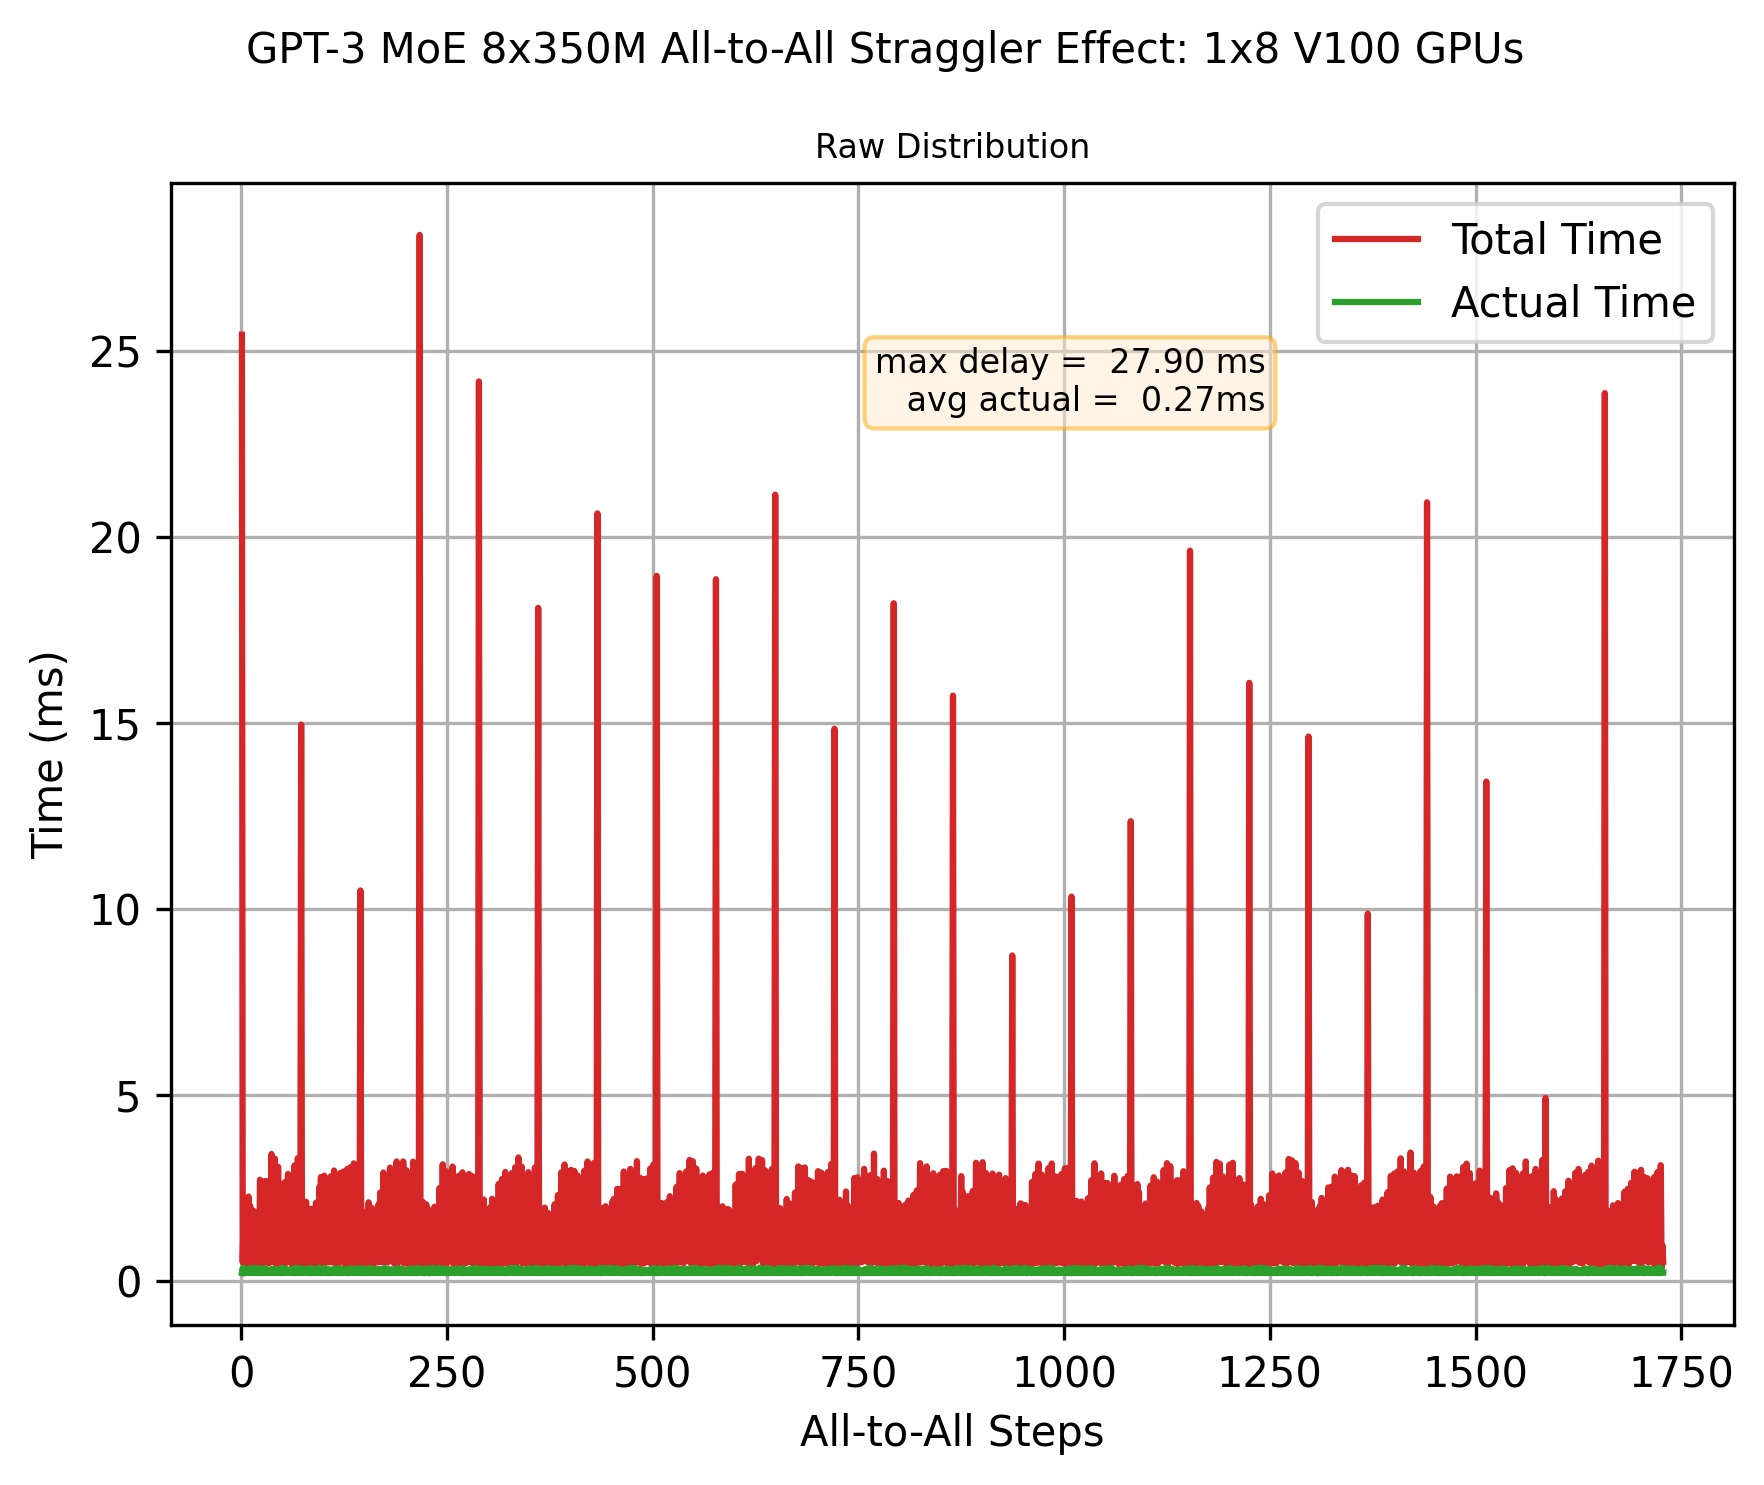

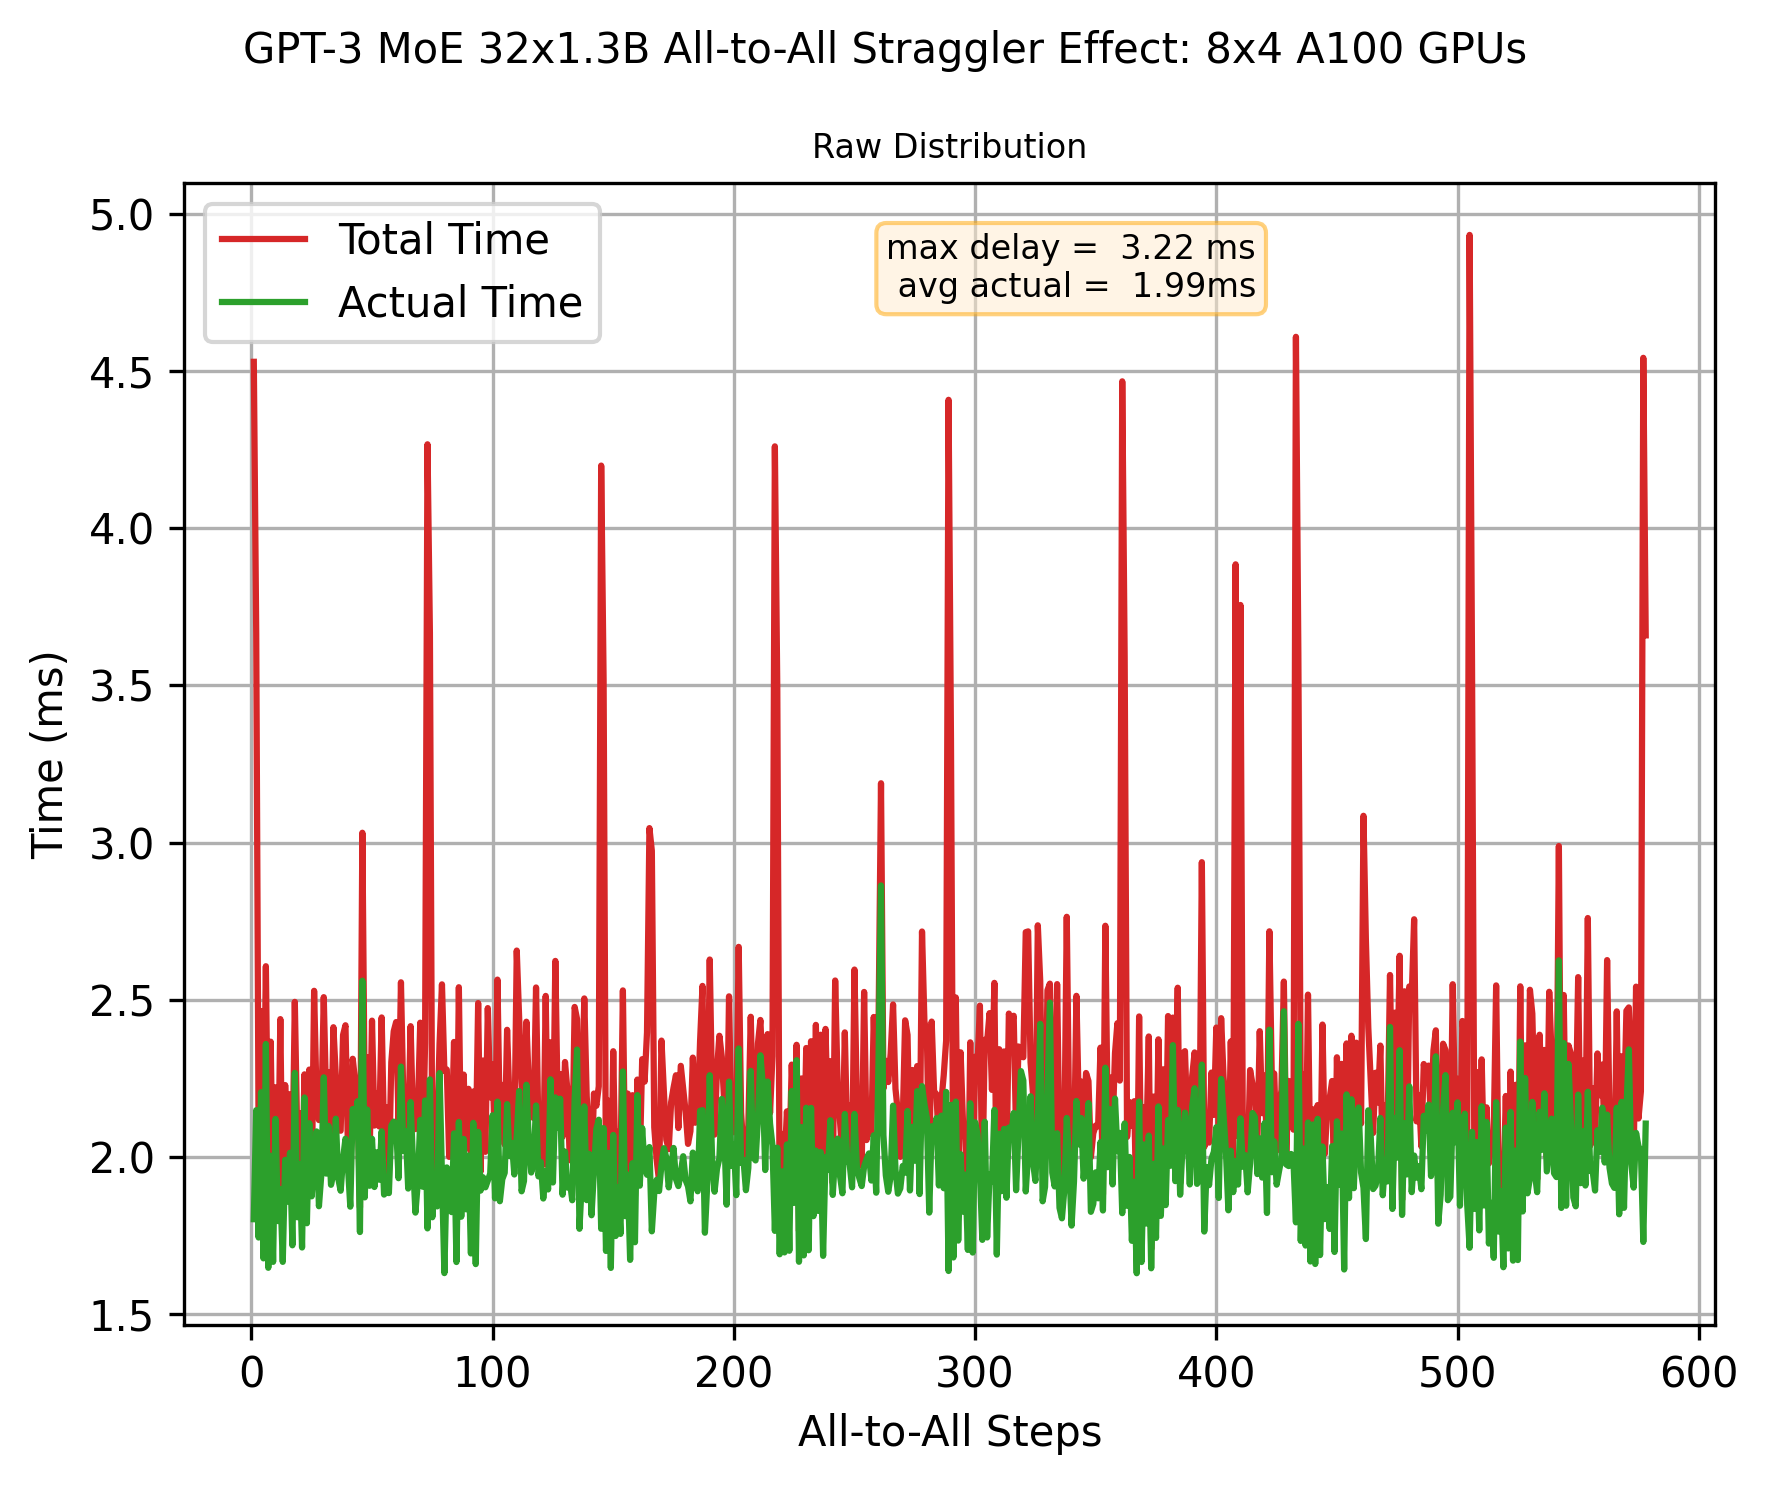

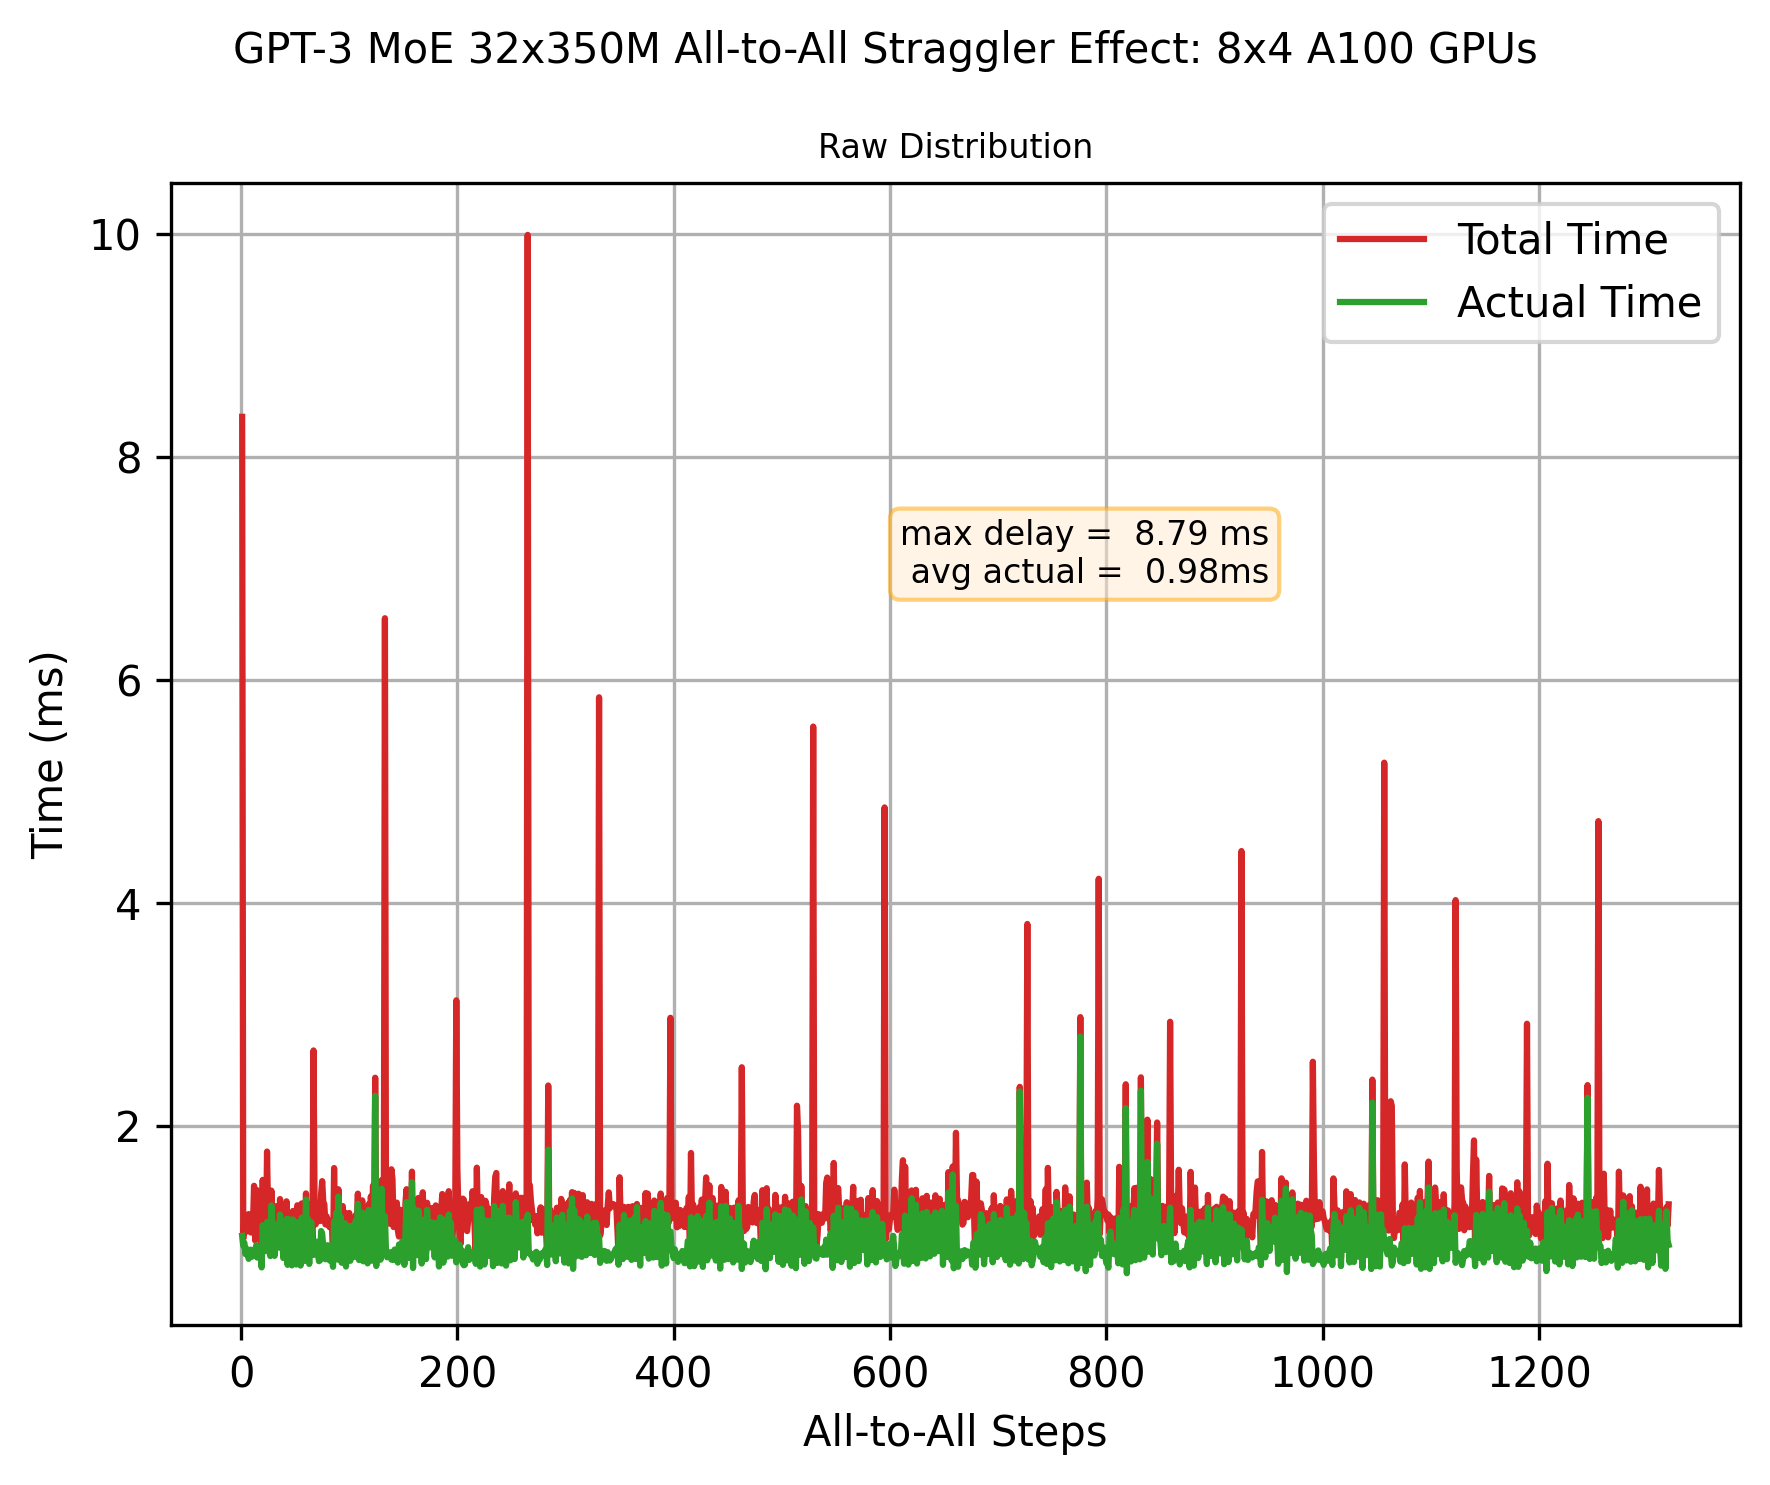

In [17]:
plot_straggler_delays(delays_dataset,
                          output_names=["GPT-3 MoE 8x350M", "GPT-3 MoE 32x1.3B", "GPT-3 MoE 32x350M"],
                          file_prefix='figures/',
                          addenda=["1x8 V100 GPUs", "8x4 A100 GPUs", "8x4 A100 GPUs"])